In [1]:
import gym
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import sys
from pyvirtualdisplay import Display
from IPython import display as disp
%matplotlib inline

In [2]:
# display options
display = Display(visible=0,size=(600,600))
display.start()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
env = gym.make("BipedalWalker-v3")
# monitor wrapper to render and make a video
env = gym.wrappers.Monitor(env, "./video_walker", video_callable=lambda ep_id: ep_id%50 == 0, force=True)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

In [4]:
class Replay_buffer():
    '''
    Code based on:
    https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py
    Expects tuples of (state, next_state, action, reward, done)
    '''
    def __init__(self, max_size=50000):
        self.storage = []
        self.max_size = max_size
        self.ptr = 0

    def push(self, data):
        if len(self.storage) == self.max_size:
            self.storage[int(self.ptr)] = data
            self.ptr = (self.ptr + 1) % self.max_size
        else:
            self.storage.append(data)

    def sample(self, batch_size):
        ind = np.random.randint(0, len(self.storage), size=batch_size)
        x, y, u, r, d = [], [], [], [], []

        for i in ind:
            X, Y, U, R, D = self.storage[i]
            x.append(np.array(X, copy=False))
            y.append(np.array(Y, copy=False))
            u.append(np.array(U, copy=False))
            r.append(np.array(R, copy=False))
            d.append(np.array(D, copy=False))

        return np.array(x), np.array(y), np.array(u), np.array(r).reshape(-1, 1), np.array(d).reshape(-1, 1)

In [5]:
class Actor(nn.Module):
    '''
    actor implementation. Actor will give us the action distribution which is why we have action_dim 
    in the last layer.
    '''
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        # walker is the most difficult env, if TD3 works for walker should work for others as well
        self.fc1 = nn.Linear(state_dim, 400) # this works best for walker. Lower to 400 does not work well.
        self.fc2 = nn.Linear(400, 300)
        self.fc3 = nn.Linear(300, action_dim)

        self.max_action = max_action

    def forward(self, state):
        a = F.relu(self.fc1(state))
        a = F.relu(self.fc2(a))
        a = torch.tanh(self.fc3(a)) * self.max_action
        return a

In [6]:
class Critic(nn.Module):
    '''critic implementation. Crutic will give us the value of the state. That is why we 
    have 1 value at the end of last layer
    '''
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        self.fc1 = nn.Linear(state_dim + action_dim, 400)
        self.fc2 = nn.Linear(400, 300) # 300, and 400 is working better.
        self.fc3 = nn.Linear(300, 1)   # most of the hyperparameters are taken from cleanrl API

    def forward(self, state, action):
        state_action = torch.cat([state, action], 1)

        q = F.relu(self.fc1(state_action))
        q = F.relu(self.fc2(q))
        q = self.fc3(q)
        return q

In [7]:
class Agent():
    def __init__(self, state_dim, action_dim, max_action):

        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
        self.critic_1 = Critic(state_dim, action_dim).to(device)
        self.critic_1_target = Critic(state_dim, action_dim).to(device)
        self.critic_2 = Critic(state_dim, action_dim).to(device)
        self.critic_2_target = Critic(state_dim, action_dim).to(device)

        self.actor_optimizer = optim.Adam(self.actor.parameters())
        self.critic_1_optimizer = optim.Adam(self.critic_1.parameters())
        self.critic_2_optimizer = optim.Adam(self.critic_2.parameters())

        self.actor_target.load_state_dict(self.actor.state_dict())
        self.critic_1_target.load_state_dict(self.critic_1.state_dict())
        self.critic_2_target.load_state_dict(self.critic_2.state_dict())

        self.max_action = max_action
        self.memory = Replay_buffer(50000)
        self.tau = 0.005
        self.gamma = 0.99
        self.policy_delay = 2

    def sample_action(self, s):
        s = torch.tensor(s.reshape(1, -1)).float().to(device)
        return self.actor(s).cpu().data.numpy().flatten()

    def train(self, time_steps):
        # main training part
        for i in range(time_steps):
            x, y, u, r, d = self.memory.sample(100) #sample 100 as a minibatch
            state = torch.FloatTensor(x).to(device)
            action = torch.FloatTensor(u).to(device)
            next_state = torch.FloatTensor(y).to(device)
            done = torch.FloatTensor(d).to(device)
            reward = torch.FloatTensor(r).to(device)

            # Select next action according to target policy and noise of the current action
            noise = torch.ones_like(action).data.normal_(0, 0.2).to(device)
            noise = noise.clamp(-0.5, 0.5)
            next_action = (self.actor_target(next_state) + noise)
            next_action = next_action.clamp(-self.max_action, self.max_action)

            # Compute target Q-value:
            target_Q1 = self.critic_1_target(next_state, next_action)
            target_Q2 = self.critic_2_target(next_state, next_action)
            target_Q = torch.min(target_Q1, target_Q2)
            target_Q = reward + ((1 - done) * self.gamma * target_Q).detach()

            # compute Q-values and Optimize Critic 1:
            current_Q1 = self.critic_1(state, action)
            loss_Q1 = F.mse_loss(current_Q1, target_Q)
            self.critic_1_optimizer.zero_grad()
            loss_Q1.backward()
            self.critic_1_optimizer.step()

            # compute Q-values and Optimize Critic 2:
            current_Q2 = self.critic_2(state, action)
            loss_Q2 = F.mse_loss(current_Q2, target_Q)
            self.critic_2_optimizer.zero_grad()
            loss_Q2.backward()
            self.critic_2_optimizer.step() # optimize two Q-values as in Double DQN
            
            # Delayed policy updates:
            if i % self.policy_delay == 0:
                # Compute actor loss:
                actor_loss = - self.critic_1(state, self.actor(state)).mean()
                
                # Optimize the actor after some delayed time steps
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()
                for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                    target_param.data.copy_(((1- self.tau) * target_param.data) + self.tau * param.data)

                for param, target_param in zip(self.critic_1.parameters(), self.critic_1_target.parameters()):
                    target_param.data.copy_(((1 - self.tau) * target_param.data) + self.tau * param.data)

                for param, target_param in zip(self.critic_2.parameters(), self.critic_2_target.parameters()):
                    target_param.data.copy_(((1 - self.tau) * target_param.data) + self.tau * param.data)

# Bipedal walker

/tmp/ipykernel_4505/3500727840.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  agent.memory.push((state, next_state, action, reward, np.float(done)))


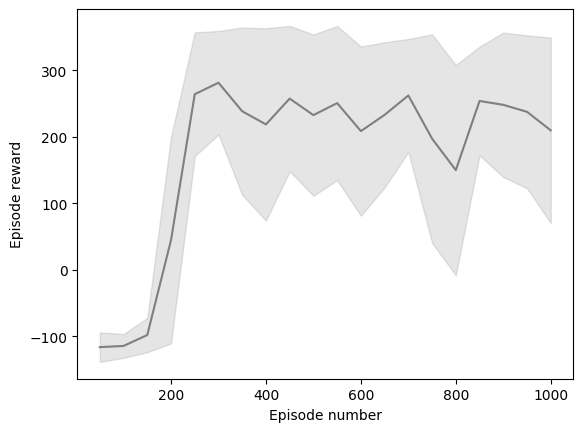

In [8]:
# training part of walker. Around 300 is the best reward
# initialise agent
agent = Agent(state_dim, action_dim, max_action)
max_episodes = 1000
max_timesteps = 2000
reward_list = []
plot_data = []
ep_reward = 0

# training procedure:
for episode in range(1, max_episodes+1):
    state = env.reset() # it will give us the initial state
    for t in range(max_timesteps):

        # select the agent action
        action = agent.sample_action(state)

        # take action in environment and get r and s'
        next_state, reward, done, _ = env.step(action)
        agent.memory.push((state, next_state, action, reward, np.float(done)))
        
        state = next_state
        ep_reward += reward
        
        # stop iterating when the episode finished
        if done or t==(max_timesteps-1):
            agent.train(t)
            break
    
    # append the episode reward to the reward list
    reward_list.append(ep_reward)
    ep_reward = 0

    
    if episode % 50 == 0:
        plot_data.append([episode, np.array(reward_list).mean(), np.array(reward_list).std()])
        reward_list = []
        plt.plot([x[0] for x in plot_data], [x[1] for x in plot_data], '-', color='tab:grey')
        plt.fill_between([x[0] for x in plot_data], [x[1]-x[2] for x in plot_data], \
                         [x[1]+x[2] for x in plot_data], alpha=0.2, color='tab:grey')
        plt.xlabel('Episode number')
        plt.ylabel('Episode reward')
        plt.show()
        disp.clear_output(wait=True)


# MountainCar

In [9]:
env = gym.make('MountainCarContinuous-v0')
# monitor wrapper to render and make a video
env = gym.wrappers.Monitor(env, "./video_mountaincar", video_callable=lambda ep_id: ep_id%50 == 0, force=True)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

/tmp/ipykernel_4505/1840956955.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  agent.memory.push((state, next_state, action, reward, np.float(done)))


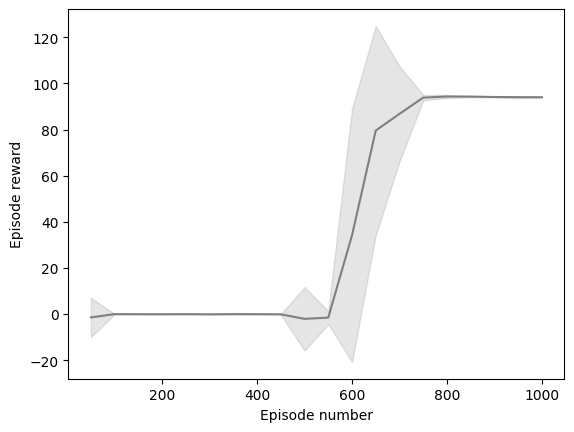

In [10]:
## training part of mountaincar around 100 is the best
# initialise agent
agent = Agent(state_dim, action_dim, max_action)
max_episodes = 1000
max_timesteps = 1000
reward_list = []
plot_data = []
ep_reward = 0

# training procedure:
for episode in range(1, max_episodes+1):
    state = env.reset()
    for t in range(max_timesteps):

        # select the agent action
        action = agent.sample_action(state)

        # take action in environment and get r and s'
        next_state, reward, done, _ = env.step(action)
        agent.memory.push((state, next_state, action, reward, np.float(done)))
        
        state = next_state
        ep_reward += reward
        
        # stop iterating when the episode finished
        if done or t==(max_timesteps-1):
            agent.train(t)
            break
    
    # append the episode reward to the reward list
    reward_list.append(ep_reward)
    ep_reward = 0

    
    if episode % 50 == 0:
        plot_data.append([episode, np.array(reward_list).mean(), np.array(reward_list).std()])
        reward_list = []
        plt.plot([x[0] for x in plot_data], [x[1] for x in plot_data], '-', color='tab:grey')
        plt.fill_between([x[0] for x in plot_data], [x[1]-x[2] for x in plot_data], \
                         [x[1]+x[2] for x in plot_data], alpha=0.2, color='tab:grey')
        plt.xlabel('Episode number')
        plt.ylabel('Episode reward')
        plt.show()
        disp.clear_output(wait=True)


#  Inverse Pendulum

In [11]:
env = gym.make('Pendulum-v1', g=9.81)
# monitor wrapper to render and make a video
env = gym.wrappers.Monitor(env, "./video_pendulum", video_callable=lambda ep_id: ep_id%50 == 0, force=True)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

/tmp/ipykernel_4505/2196228886.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  agent.memory.push((state, next_state, action, reward, np.float(done)))


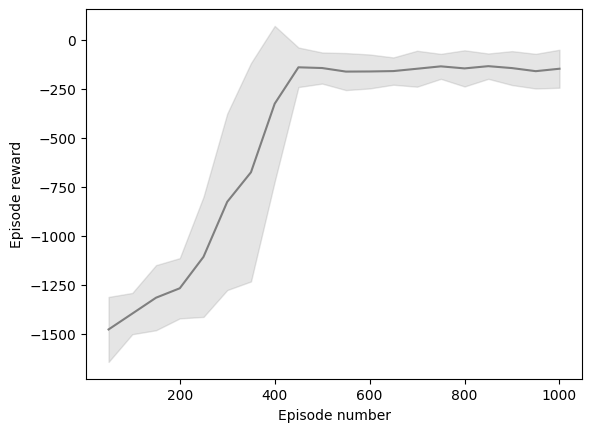

In [12]:
## training part of inverse pendulum around 0 is the best and maximum reward agent can get
# initialise agent
agent = Agent(state_dim, action_dim, max_action)
max_episodes = 1000
max_timesteps = 200
reward_list = []
plot_data = []
ep_reward = 0

# training procedure:
for episode in range(1, max_episodes+1):
    state = env.reset()
    for t in range(max_timesteps):

        # select the agent action
        action = agent.sample_action(state)

        # take action in environment and get r and s'
        next_state, reward, done, _ = env.step(action)
        agent.memory.push((state, next_state, action, reward, np.float(done)))
        
        state = next_state
        ep_reward += reward
        
        # stop iterating when the episode finished
        if done or t==(max_timesteps-1):
            agent.train(t)
            break
    
    # append the episode reward to the reward list
    reward_list.append(ep_reward)
    ep_reward = 0

    
    if episode % 50 == 0:
        plot_data.append([episode, np.array(reward_list).mean(), np.array(reward_list).std()])
        reward_list = []
        plt.plot([x[0] for x in plot_data], [x[1] for x in plot_data], '-', color='tab:grey')
        plt.fill_between([x[0] for x in plot_data], [x[1]-x[2] for x in plot_data], \
                         [x[1]+x[2] for x in plot_data], alpha=0.2, color='tab:grey')
        plt.xlabel('Episode number')
        plt.ylabel('Episode reward')
        plt.show()
        disp.clear_output(wait=True)


# References
https://github.com/openai/baselines

https://github.com/DLR-RM/stable-baselines3

https://github.com/vwxyzjn/cleanrl

https://github.com/hmomin/TD3-Bipedal-Walker